In [3]:
from enum import Enum
import random
import math
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import copy
import json
import pandas as pd
import csv
from abc import ABC, abstractmethod
from collections import deque
from queue import PriorityQueue

In [4]:
# Directional Vectors
DY = [-1, 1, 0, 0]
DX = [0, 0, 1, -1]   

# Parent class of all Enums
class Flags(Enum):
    def __eq__(self, other):
        if isinstance(other, Flags):
            return self.value == other.value
        return self.value == other

# Represent Cell Types
class Cell(Flags):
    BLOCKED = 0
    OPEN = 1
    LEAK = 3

# Represent Belief Updates
class Belief(Flags):
    NO_LEAK = 0
    NO_BEEP = 1
    BEEP = 2


In [5]:
# Represents Probabilities of pairs of cells for Bot 8/9
class ProbKB:
    def __init__(self, n, board = None, default_prob = 0):
        """Initialize every unique pair of cells"""

        # Key : (i, j, k, l) represnts P(Leak in (i, j) AND Leak in (k, l)
        self.n = n
        self.probs = {}
        for i in range(n):
            for j in range(n):
                for k in range(i, n):
                    for l in range(j + 1, n) if i == k else range(n):
                        probability = (default_prob if board and board[i][j] != Cell.BLOCKED and board[k][l] != Cell.BLOCKED else 0)
                        self.probs[((i, j), (k, l))] = probability

    def zero_out(self, pos):
        for key in self.probs:
            if pos in key:
                self.probs[key] = 0

    def get(self, a, b):
        """Get P(L_a AND L_b) from the knowledgebase"""
        key = self.key(a, b)
        return self.probs[key]

    def set(self, a, b, val):
        """Set a new value of P(L_a AND L_b) """
        key = self.key(a, b)
        self.probs[key] = val

    def key(self, a, b):
        """Create the key for the unique pair"""
        return tuple(sorted([a, b]))
        

In [6]:
# Helper Methods
def manhattan(curr, goal):
    """Compute manhattan distance between two cells"""
    r, c = curr
    goal_r, goal_c = goal
    return abs(goal_r - r) + abs(goal_c - c)

## The Ship
The layout of the ship (walls, hallways, etc) is on a square grid, generated in the following way:

• Start with a square grid, D × D, of ‘blocked’ cells. Define the neighbors of cell as the adjacent cells in the
up/down/left/right direction. Diagonal cells are not considered neighbors.

• Choose a square in the interior to ‘open’ at random.

• Iteratively do the following:

– Identify all currently blocked cells that have exactly one open neighbor.

– Of these currently blocked cells with exactly one open neighbor, pick one at random.

– Open the selected cell.

– Repeat until you can no longer do so.

• Identify all cells that are ‘dead ends’ - open cells with one open neighbor.

• For approximately half these cells, pick one of their closed neighbors at random and open it.


In [7]:
# Represents the Ship
class Ship:
    def __init__(self, seed = None, leaks = 1, D = 50):
        self.actions = {}
        self.D = D
        self.leaks = leaks
        self.seed = seed
        self.board = []
        self.open_cells = []
        self.initial_leaks = []
        
        self.init_board()
        self.init_leaks()
        self.distances = self.init_distances()

    
    def init_board(self):
        """Initialize the 50x50 board following Project 1 Algorithm"""
        n = self.D
        random.seed(self.seed)
        
        self.board = [[Cell.BLOCKED for _ in range(n)] for _ in range(n)]
        rand_row = random.randint(0, n - 1)
        rand_col = random.randint(0, n - 1)
        
        self.board[rand_row][rand_col] = Cell.OPEN
        valid_cells = set()
        open_cells = [(rand_row, rand_col)]
        valid_cells.add((rand_row, rand_col))

        while True:
            candidates = self.get_candidates(valid_cells)
            if not candidates:
                break

            rand_cell = random.choice(candidates)
            r, c = rand_cell
            self.board[r][c] = Cell.OPEN
            valid_cells.add((r, c))
            open_cells.append((r, c))

        # Collect all open cells with exactly 1 open neighbor
        dead_ends = []
        for oc in open_cells:
            r, c = oc
            open_neighbors = self.get_neighbor_count(r, c, Cell.OPEN)
            if open_neighbors == 1:
                dead_ends.append(oc)

        # Open approximately half of the dead ends
        num_dead_ends = len(dead_ends)
        while len(dead_ends) > num_dead_ends // 2:

            # Pick a random dead end and open one of it's neighbors
            rand_idx = random.randint(0, len(dead_ends) - 1)
            r, c = dead_ends[rand_idx]
            closed_neighbors = self.get_neighbors(r, c, Cell.BLOCKED)
            if closed_neighbors:
                rand_cell = random.choice(closed_neighbors)
                nr, nc = rand_cell
                self.board[nr][nc] = Cell.OPEN
                open_cells.append((nr, nc))
                dead_ends.pop(rand_idx)

                # Check for newly opened dead ends
                open_neighbors = self.get_neighbors(nr, nc, Cell.OPEN)
                for neighbor in open_neighbors:
                    r, c = neighbor

                    # If this pair is also a dead end, remove it
                    try:
                        idx = dead_ends.index((r, c))
                        dead_ends.pop(idx)
                    except ValueError: # was not a dead end
                        continue
                        
        self.open_cells = open_cells

    def init_leaks(self):
        """Randomly selects a cell to be the leak"""
        for i in range(self.leaks):
            open_cell = random.choice(self.open_cells) # Choose a random cell from the open cells
            r, c = open_cell
    
            self.board[r][c] = Cell.LEAK
            self.initial_leaks.append((r, c))
        
    # Helper Methods
    def is_valid(self, r, c):
        """Determine if a row x col is within the bounds of the board"""
        return r >= 0 and c >= 0 and r < self.D and c < self.D

    def get_neighbors(self, r, c, target):
        """Get all of the valid neighbors of the desired type"""
        res = []
        for i in range(4):
            nr = DY[i] + r
            nc = DX[i] + c
            if self.is_valid(nr, nc) and self.board[nr][nc] == target:
                res.append((nr, nc))
        
        return res

    def get_neighbor_count(self, r, c, target):
        """Get the number of valid neighbors of the desired type"""
        return len(self.get_neighbors(r, c, target))

    def get_candidates(self, open_cells):
        n = self.D
        candidates = []
        to_remove = []
        for pair in open_cells:
            r, c = pair
            closed_neighbors = self.get_neighbors(r, c,  Cell.BLOCKED)
            valid_found = 0
            for neighbor in closed_neighbors:
                n_r, n_c = neighbor
                open_neighbors = self.get_neighbor_count(n_r, n_c, Cell.OPEN)
                if open_neighbors == 1:
                    valid_found += 1
                    candidates.append((n_r, n_c))

            if valid_found == 0:
                to_remove.append(pair) 

        for pair in to_remove:
            open_cells.remove(pair)
            
        return candidates

    def init_distances(self, testing = True):
        """Calculate distance from the leak to every other cell in the board"""
        # param: `testing` defaults to True
        # This is a flag that, when True, will compute manhattan distances instead of literal distances
        # Do not change this until we run actual tests, as BFS from every cell takes 3min+
        
        n = len(self.board)

        # Get the distance between any cell and every other cell
        def distances_from_cell(start):
            result = [[-1 for _ in range(n)] for _ in range(n)]

            # Testing flag to use MANHATTAN DISTANCE instead of LITERAL DISTANCE
            if testing:
                for i in range(n):
                    for j in range(n):
                        result[i][j] = manhattan(start, (i, j))
                return result

            queue = deque()
            vis = set()
            queue.append([start, 0])
            while queue:
                curr, dist = queue.popleft()
                r, c = curr
                vis.add(curr)
                result[r][c] = dist
                for i in range(4):
                    nr = DY[i] + r
                    nc = DX[i] + c
                    if self.is_valid(nr, nc) and (nr, nc) not in vis and self.board[nr][nc] != Cell.BLOCKED:
                        queue.append([(nr, nc), dist + 1])
                        
            return result
            
        distances = {}
        for cell in self.open_cells:
            distances[cell] = distances_from_cell(cell)

        return distances
    
    def display(self, path = None):
        """Display a grid image of the current board (FOR USE IN NOTEBOOK)"""
        if isinstance(path, tuple):
            loc = path
            path = [loc]
        
        n = self.D
        copy_board = [row[:] for row in self.board]
        leaks = []
        if not isinstance(copy_board[0][0], (float, int)):
            for i in range(n):
                for j in range(n):
                    copy_board[i][j] = copy_board[i][j].value
                    if copy_board[i][j] == Cell.LEAK:
                        leaks.append((i, j))

        if path:
            for pair in path:
                r, c = pair
                copy_board[r][c] = 2

        for leak in leaks:
            r, c = leak
            copy_board[r][c] = 3
                
        image_data = np.array(copy_board)
        plt.imshow(image_data, "Blues")
        # plt.axis("off")
        plt.show()
        

## The Bots
The bot occupies an open cell somewhere in the ship (to be determined shortly). The bot can move to one adjacent cell
every time step (up/down/left/right). Each bot will have access to a different kind of sensor data to help determine
where the atmosphere leak in the ship is - the purpose of the bot is to utilize the available sensor information to
locate and reach the atmosphere leak as quickly as possible. The bot will start at a randomly selected open square
in the ship. The bot knows / can sense when it enters the cell where the leak is located.

##### At each timestep - the bot must choose whether to move or to sense.

In [8]:
# Putting this here because I think it could be an efficient architecture, basically skeleton code
class Bot(ABC):
    def __init__(self, ship):
        self.ship = ship
        self.timestep = 0
        self.path = []
        self.init_bot()
    
    @abstractmethod
    def simulate(self):
        raise NotImplementedError()

    @abstractmethod
    def move(self):
        raise NotImplementedError()

    @abstractmethod
    def sense(self):
        raise NotImplementedError()

    def init_bot(self):
        """Place bot in random location on the board"""
        r, c = random.choice(self.ship.open_cells)
        self.position = (r, c)


    def bfs(self, src, goal):
        """Shortest Path from SRC to GOAL -> Returns GOAL, PATH"""

        # Add support for multiple goal states
        if isinstance(goal, tuple):
            state = goal
            goal = set()
            goal.add(state)
        
        queue = deque()
        queue.append((src, deque()))
        vis = set()
        while queue: 
            curr, path = queue.popleft()
            new_path = path.copy()
            new_path.append(curr)
            vis.add(curr)

            if curr in goal:
                return (curr, new_path)
              
            r, c = curr
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.ship.is_valid(nr, nc) and (nr, nc) not in vis and self.ship.board[nr][nc] != Cell.BLOCKED:
                    queue.append(((nr, nc), new_path))   

        return (None, deque())
        

In [9]:
# Super class for all Probabilistic Bots
class ProbabilisticBot(Bot):
    def __init__(self, ship):
        super().__init__(ship)
        self.prob_matrix = self.init_prob_matrix()
        
    def init_prob_matrix(self):
        """Initialize Probability Matrix, originally giving all OPEN CELLS equal chance of having the leak"""
        board = self.ship.board
        n = len(board)
        num_open_cells = len(self.ship.open_cells)
        default_prob = (1 / num_open_cells)
        prob_matrix = [[0 for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                if board[i][j] != Cell.BLOCKED:
                    prob_matrix[i][j] = default_prob
        return prob_matrix

    def get_beep_prob(self, cell, leak):
        """Calculate probability of hearing a beep given distance from leak"""
        cell_r, cell_c = cell
        dist_from_leak = self.ship.distances[leak][cell_r][cell_c]
        return np.e ** ( (-self.alpha) * (dist_from_leak - 1) )

    def find_highest_prob(self): # Maybe problematic for multiple leaks
        """Get the cell with the current highest chance of containing the leak"""
        n = len(self.ship.board)
        max_prob = -np.inf
        min_dist = np.inf
        best_cell = None
        total = 0

        # Iterate over every potentially leaky cell, find cell(s) with best chance
        for r in range(n):
            for c in range(n):
                if self.ship.board[r][c] == Cell.BLOCKED:
                    continue
                    
                curr_prob = self.probability_at_pos((r, c))
                curr_dist = self.ship.distances[self.position][r][c]
                total += curr_prob
    
                # New Best Found
                if curr_prob > max_prob or (curr_prob == max_prob and curr_dist < min_dist):
                    max_prob = curr_prob
                    min_dist = curr_dist
                    best_cell = (r, c)

        return best_cell

    def probability_at_pos(self, pos):
        r, c = pos
        return self.prob_matrix[r][c]


### Bot 1: 

All cells outside the initial detection square start with the possibility of containing the leak
(essentially, the bot starts having taken a sense action, and detected nothing). When the bot enters
a cell (or starts in a cell), however, if it is not the leak cell, it is marked as not containing the leak. If the
bot detects no leak in proximity - all cells in the detection square are marked as not containing the leak. If
the bot detects a leak in proximity - all cells in the detection square not already marked as not containing the
leak are marked as possibly containing the leak, and all cells outside the detection square are marked as not
containing the leak. Note that if a single square remains that is marked as containing the leak and all others
do not contain the leak - the leak must be in that one marked cell. Bot 1 acts in the following way:

– At any time that has not detected a leak, it will proceed to the nearest cell that might contain the leak
(breaking ties at random), enter it, and take the sense action, updating what it knows based on the results.

– At any time that a leak has been detected, it will proceed to the nearest cell that might contain the leak,
enter it, and in doing so either find the leak or rule that cell out.

This proceeds until the leak is discovered.

In [10]:
class BotOne(Bot):    
    def __init__(self, ship, k = 1):
        super().__init__(ship)

        self.k = k
        self.unseen = set(ship.open_cells)
        self.not_leaky = set() 
        self.leaky = set() 
        self.future_path = deque()       
                
    def action(self):
        """Choose to move or sense"""
        pos = self.position
        
        if pos in self.ship.initial_leaks:
            self.ship.initial_leaks.remove(pos)
            self.sense(self.k)
            return True
        elif pos in self.leaky:
            self.not_leaky.add(pos)
            self.leaky.remove(pos)

        if self.leaky:
            self.move()
        else:
            if pos in self.not_leaky:
                self.move()
            else:
                self.sense(self.k)               
                
        return False

    def move(self):
        """Update self.position and cell enum to mark path"""
        curr = self.position
        r, c = curr
        self.path.append(curr)
        
        if not self.future_path:        
            self.future_path = self.bfs(curr, self.leaky if self.leaky else self.unseen)[1]

        # Update path to next point in path
        next_position = self.future_path.popleft()
        nr, nc = next_position
        self.position = next_position
        
    def sense(self, k = 1):
        """Sense if leak is within (2k + 1)^2 square"""
        detection_square = []
        r, c = self.position

        leakExists = False
        
        for row in range(r - k, r + k + 1):
            for col in range (c - k, c + k + 1):
                if self.ship.is_valid(row, col) and self.ship.board[row][col] != Cell.BLOCKED:
                    loc = (row, col)
                    detection_square.append(loc)

                    if loc in self.ship.initial_leaks:
                        leakExists = True 

        if not leakExists:
            # If detection square isn't leaky, add all cells to not_leaky set and remove any that may exist in leaky set
            for cell in detection_square:
                self.not_leaky.add(cell)
                if cell in self.unseen:
                    self.unseen.remove(cell)
                if cell in self.leaky:
                    self.leaky.remove(cell)
        else:
            # If detection square is leaky, add all squares that aren't already checked into leaky set
            for cell in detection_square:
                if cell not in self.not_leaky:
                    self.leaky.add(cell)
                if cell in self.unseen:
                    self.unseen.remove(cell)

        self.temp = detection_square
            
        return leakExists

    def simulate(self):
        success = False

        while not success:
            res = self.action()
            if res:
                success = True

            self.timestep += 1

        return success, self.path, self.timestep

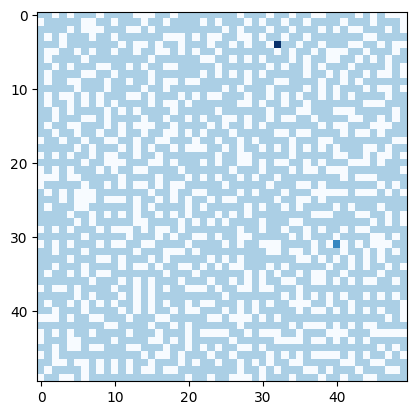

Bot position: (31, 40)
Leak position: [(4, 32)]


In [11]:
ship = Ship()
bot = BotOne(ship, 5)

ship.display(bot.position)
print("Bot position: %s" % (bot.position,))
print("Leak position: %s" % (ship.initial_leaks,))

True 364 steps


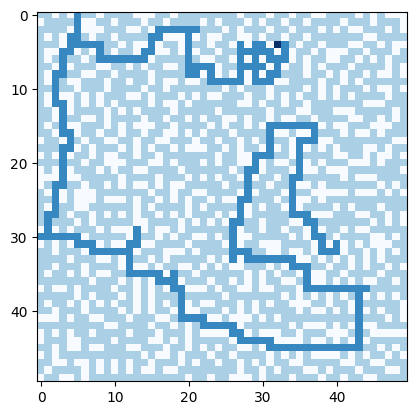

In [12]:
res = bot.simulate()
print(str(res[0]) + " " + str(res[2]) + " steps")
ship.display(bot.path)

In [13]:
print("100 tests:")
sum = 0

for seed in SEEDS: #np.random.randint(low=0, high=1000000000, size=100):
    seed = int(seed)
    ship = Ship(seed)
    bot = BotOne(ship, 2)
    res = bot.simulate()
    sum += res[2]
    print(str(seed) + ": " + str(res[0]) + " " + str(res[2]) + " steps")

avg = sum / 100
print("\naverage: " + str(avg) + " steps")

100 tests:


NameError: name 'SEEDS' is not defined

### Bot 2:

A bot of your own design that uses the data from the detection square.

Split the ship into *k* by *k* tiles. Use Prim's algorithm to construct a minimum spanning tree connecting all of the tiles. First, assign the bot's initial location $v_s$ to the tile containing it $T_s$. Suppose you are exploring the neighbors of a tile $T_1$ (with vertex $v_1$) and come across a tile $T_2$. Then, find the vertex in $T_2$ that is closest to $v_1$, and assign it to $T_2$. Now, we have a minimum spanning tree that will guarantee we scan every vertex.

Construct a path using the vertices in the MST. Once you detect the leak, use BFS on the leaky squares to find the exact location of the leak.

In [86]:
class Vertex():
    def __init__(self, tile_coord, cell_coord=None):
        self.tile_coord = tile_coord
        self.cell_coord = cell_coord
        self.has_assigned_coord = cell_coord is not None

    def __str__(self):
        return f"V({self.tile_coord})"

    def assign_coord(self, cell_coord):
        self.cell_coord = cell_coord
        self.has_assigned_coord = True

    def has_coord(self):
        return self.has_assigned_coord

class MST():
    def __init__(self, ship, k, init_pos):
        self.ship = ship
        self.k = k
        #self.vertex_id = 0
        self.edges = dict()
        self.init_pos = init_pos

        self.D = math.ceil(ship.D / self.k)
        self.vertices = [[None for _ in range(self.D)] for _ in range(self.D)]
        # self.ind_board = [[-1 for _ in range(self.D)] for _ in range(self.D)]
        
        self.create_MST()
    
    def valid_vertex(self, r, c):
        if r < 0 or c < 0:
            return False
        if r >= self.D or c >= self.D:
            return False
        return True

    def create_MST(self):
        self.init_vertices()
        self.prim()
        pass

    def init_vertices(self):
        init_vertex = self.cell_coord_to_vertex(self.init_pos)
        
        for tile_row in range(self.D): # tile rows
            for tile_col in range(self.D): # tile columns
                if not self.tile_visitable(tile_row, tile_col):
                    # self.vertex_id += 1 # skip curr id
                    continue

                vertex = Vertex(tile_coord=(tile_row, tile_col))
                if init_vertex == (tile_row, tile_col): # if 
                    # print(f"asdf {r} {c} COORD {self.init_pos} IND {self.vertex_count}")
                    vertex.assign_coord(self.init_pos)
                    self.start_vertex = vertex
                    
                #self.ind_board[tile_row][tile_col] = self.vertex_id
                self.vertices[tile_row][tile_col] = vertex
                #self.vertex_id += 1

    def is_valid(self, r, c):
        """Determine if a row x col is within the bounds of the board"""
        return r >= 0 and c >= 0 and r < self.D and c < self.D

    def tile_visitable(self, tile_row, tile_col):
        """Check if given tile has at least one open cell"""
        start_row = tile_row * self.k
        start_col = tile_col * self.k
        # r, c = cell displacement within tile
        for r in range(self.k): 
            for c in range(self.k):
                if self.ship.board[start_row + r][start_col + c] == Cell.OPEN:
                    return True
        print(f"Tile ({tile_row}, {tile_col}) is not visitable")
        return False

    def get_tile_neighbors(self, tile_coord):
        """Get all the valid neighbors of tile"""
        tile_row, tile_col = tile_coord
        
        neighbors = []
        for i in range(4):
            nr = DY[i] + tile_row
            nc = DX[i] + tile_col
            if self.is_valid(nr, nc) and self.vertices[nr][nc] != None:
                neighbors.append(self.vertices[nr][nc])

        return neighbors

    def prim(self):
        open = PriorityQueue()
        closed = set()
        # dist to parent, vertex, parent
        # open.put((0, self.start_vertex, None))

        closed.put(self.start_vertex.tile_coord)
        for neighbor in self.get_tile_neighbors(self.start_vertex.tile_coord):
            pass
            print(neighbor)
        # TODO: finish method

    def cell_coord_to_vertex(self, cell_coord): 
        r, c = cell_coord
        return (math.floor(r / self.k), math.floor(c / self.k))
    
    
    # Input vertex ind; get the coordinates of assigned point
    def vertex_to_cell_coord(self, r, c):
        vertex = self.vertices[r][c]
        if vertex == None:
            return None
        return vertex.cell_coord
    
    def cell_in_tile(self, cell_coord, tile_coord):
        cell_tile = self.cell_coord_to_vertex(cell_coord)
        return cell_tile == tile_coord
    
    # NOTE: can improve by taking list of goal tiles and try to visit all at once
    def tile_bfs(self, src, goal):
        """Shortest Path from vertex A to tile B"""

        # Add support for multiple goal states
        if isinstance(goal, tuple):
            state = goal
            goal = set()
            goal.add(state)
        
        queue = deque()
        queue.append((src, deque()))
        vis = set()
        while queue: 
            curr, path = queue.popleft()
            new_path = path.copy()
            new_path.append(curr)
            vis.add(curr)

            # TODO: change to checking whether curr is in a tile index in goal
            if curr in goal:
                return (curr, new_path)
              
            r, c = curr
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.ship.is_valid(nr, nc) and (nr, nc) not in vis and self.ship.board[nr][nc] != Cell.BLOCKED:
                    queue.append(((nr, nc), new_path))   

        return (None, deque())
    

In [87]:
class BotTwo(BotOne):    
    def __init__(self, ship, k = 1):
        super().__init__(ship, k=k)
    
    # TODO: implement move, sense, simulate as needed

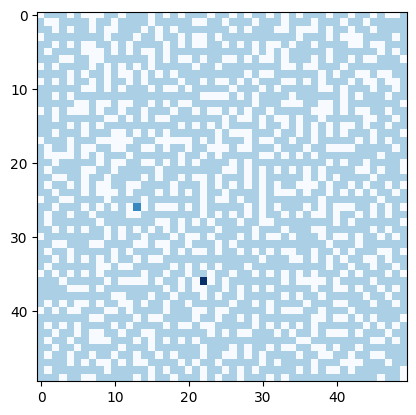

Bot position: (26, 13)
Leak position: [(36, 22)]


In [88]:
seed = 42
ship = Ship(seed=seed)
bot = BotTwo(ship, 5)

ship.display(bot.position)
print("Bot position: %s" % (bot.position,))
print("Leak position: %s" % (ship.initial_leaks,))

In [89]:
testMST = MST(ship=ship, k=5, init_pos=bot.position)
print(testMST.start_vertex)
print(testMST.vertices)
for i in testMST.vertices:
    for j in i:
        print(j, end=", ")
    print()


V((4, 2))
V((6, 2))
V((5, 3))
V((5, 1))
V((5, 2))
[[<__main__.Vertex object at 0x7feab8b7a6e0>, <__main__.Vertex object at 0x7feabd47d2d0>, <__main__.Vertex object at 0x7feabd47e140>, <__main__.Vertex object at 0x7feabd47f8e0>, <__main__.Vertex object at 0x7feabd47ec50>, <__main__.Vertex object at 0x7feabd47f160>, <__main__.Vertex object at 0x7feabd47fd00>, <__main__.Vertex object at 0x7feabd47c100>, <__main__.Vertex object at 0x7feabd47e230>, <__main__.Vertex object at 0x7feabd47d7b0>], [<__main__.Vertex object at 0x7feab62d7e80>, <__main__.Vertex object at 0x7feabd47c340>, <__main__.Vertex object at 0x7feabd47d540>, <__main__.Vertex object at 0x7feabd47f370>, <__main__.Vertex object at 0x7feabd47e350>, <__main__.Vertex object at 0x7feabd47cb80>, <__main__.Vertex object at 0x7feabd47d270>, <__main__.Vertex object at 0x7feabd47ceb0>, <__main__.Vertex object at 0x7feabd47cd00>, <__main__.Vertex object at 0x7feabd47f580>], [<__main__.Vertex object at 0x7feabd47c9d0>, <__main__.Vertex obj

### Bot 3: 

All cells (other than the bot’s initial cell) start with equal probability of containing the leak. Bot 3
proceeds in the following well:

– At any time, the bot is going to move to the cell that has the highest probability of containing the leak
(breaking ties first by distance from the bot, then at random).

– After entering any cell, if the cell does not contain a leak, the bot will take the sense action. Based on
the results, it updates the probability of containing the leak for each cell∗.

– After the beliefs are updated, this repeats, the bot proceeding to the cell that as the highest probability
of containing the leak (breaking ties first by distance from the bot, then at random)

In [8]:
class BotThree(ProbabilisticBot):
    def __init__(self, ship, alpha):
        super().__init__(ship)
        self.alpha = alpha
        self.path = set()
        
    def move(self):
        """Move to the cell with the highest probability (of least distance)"""
        best_cell = self.find_highest_prob()
        r, c = best_cell
        print("Moving from {} to {} with probability {}".format(self.position, best_cell, self.probability_at_pos((r, c))))
        path = self.bfs(self.position, best_cell)[1]
        for cell in path:
            self.position = cell
            r, c = cell
            if cell in self.ship.initial_leaks:
                return True

            if self.probability_at_pos((r, c)) != 0:
                self.update_no_leak()
                
            self.path.add(cell)      
            self.timestep += 1
        
        return False
        
    def sense(self):
        """Determine whether or not beep was heard from current position (also return the probability)"""
        r, c = self.position
        beep_prob = self.get_beep_prob(self.position, self.ship.initial_leaks[0])
        return (random.uniform(0, 1) <= beep_prob, beep_prob)

    def simulate(self):
        n = len(self.ship.board)
        success = False
        while not success:
            
            reached_end = self.move()
            prob_sum = self.verify_probability()
            #print(prob_sum)
            
            if reached_end: 
                success = True
            else:
                # Sense for beep, update probabilities
                heard_beep, beep_prob = self.sense()
                self.update_based_on_beep(heard_beep, beep_prob)      
                self.timestep +=  1

        return success, self.path, self.timestep   
    
    def update_no_leak(self):
        """Update prior beliefs based on entering a cell with no leak"""
        n = len(self.ship.board)
        current_matrix = self.prob_matrix
        result_matrix = [[0 for _ in range(n)] for _ in range(n)]
        r, c = self.position

        not_curr = 1 - current_matrix[r][c] 
        for i in range(n):
            for j in range(n):
                result_matrix[i][j] = current_matrix[i][j] / not_curr
                
        result_matrix[r][c] = 0
        self.prob_matrix = result_matrix
        

    def update_based_on_beep(self, heard_beep, beep_prob):
        """Update prior beliefs based on hearing or not hearing a beep at a given cell"""
        n = len(self.ship.board)
        current_matrix = self.prob_matrix
        result_matrix = [[0 for _ in range(n)] for _ in range(n)]
        denominator = 0
        for i in range(n):
            for j in range(n):
                beep_given_here = self.get_beep_prob((i, j), self.position)
                numerator = (beep_given_here if heard_beep 
                             else 1 - beep_given_here) * current_matrix[i][j]
                
                denominator += numerator
                result_matrix[i][j] = numerator

        for i in range(n):
            for j in range(n):
                result_matrix[i][j] /= denominator
                    
        self.prob_matrix = result_matrix

    def verify_probability(self):
        """Verify that proabilities sum up to 1.00 after updates"""
        n = len(self.ship.board)
        total = 0
        for i in range(n):
            for j in range(n):
                total += self.probability_at_pos((i, j))

        return total


In [ ]:
seed = random.randint(0, 1000000000)
ship = Ship(D = 50, seed = seed)
print(seed)
bot = BotThree(ship, .3)
ship.display(bot.position)
success, path, steps = bot.simulate()
ship.display(list(path))
steps

In [ ]:
total = 0
for i in np.random.randint(low=0, high=1000000000, size=100):
    ship = Ship(D = 50, seed = int(i))
    bot = BotThree(ship, 1)
    _, _, steps = bot.simulate()
    total += steps
    print(i, steps)

total / 100

### Bot 5: 

In the above sections, we considered a single leak. But suppose there are two leaks simultaneously that need plugging.
Assume that once one leak is located (and the square entered) it is plugged, leaving one remaining leak to locate
and plug.

#### Deterministic Leak Detection
– Bot 5: Bot 5 is exactly Bot 1, but removes the first leak once its cell is entered, and continues until the
second leak is also identified and plugged.

In [ ]:
class BotFive(BotOne):
    def __init__(self, ship, k = 1):
        super().__init__(ship)
    
    def simulate(self):
        success = [False, False]

        while not success[1]:
            res = self.action()
            if res:
                print("Plugged Leak at {}".format(self.position))
                if not success[0]:
                    success[0] = True
                else:
                    success[1] = True

            self.timestep += 1

        return success, self.path, self.timestep


In [ ]:
ship = Ship(None, 2)
bot = BotFive(ship, 2)

ship.display(bot.position)
print("Bot position: %s" % (bot.position,))
print("Leak position: %s" % (ship.initial_leaks,))

In [ ]:
res = bot.simulate()
print(str(res[0]) + " " + str(res[2]) + " steps")
ship.display(bot.path)

In [ ]:
print("100 tests:")
sum = 0

for seed in SEEDS: #np.random.randint(low=0, high=1000000000, size=100):
    seed = int(seed)
    ship = Ship(seed, 2)
    bot = BotFive(ship, 2)
    res = bot.simulate()
    sum += res[2]
    print(str(seed) + ": " + str(res[0]) + " " + str(res[2]) + " steps")

avg = sum / 100
print("\naverage: " + str(avg) + " steps")

### Bot 7: 
Bot 7 is exactly Bot 3, but removes the first leak once its cell is entered, and then continues
searching and updating until the second leak is identified and plugged.

In [16]:
class BotSeven(BotThree):
    def __init__(self, ship, alpha):
        super().__init__(ship, alpha)

    def simulate(self):
        n = len(self.ship.board)
        success = False
        leaks_found = [False, False]
        current_leak = 0
        leak_locations = self.ship.initial_leaks[:]
        while True:
            
            reached_end = self.move()
            prob_sum = self.verify_probability()
            
            if reached_end: 
                self.update_no_leak()
                leaks_found[current_leak] = True
                current_leak += 1
                print("Plugged leak at {}".format(self.position))
                self.ship.initial_leaks.remove(self.position)
                if current_leak == 2:
                    break
                    
            # Sense for beep, update probabilities

            heard_beep, beep_prob = self.sense()
            self.update_based_on_beep(heard_beep, beep_prob)      
            self.timestep +=  1
            
        self.ship.initial_leaks = leak_locations
        return success, self.path, self.timestep   

    
        

892714813
[(46, 48), (35, 10)]


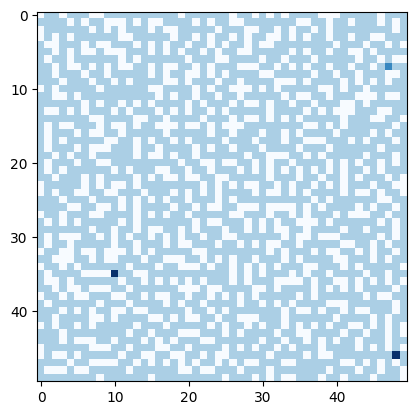

Moving from (7, 47) to (7, 47) with probability 0.0006131207847946045
Moving from (7, 47) to (36, 0) with probability 0.0006188526329792107
Moving from (36, 0) to (49, 37) with probability 0.0006605974355379476
Moving from (49, 37) to (0, 9) with probability 0.0006755967285060939
Moving from (0, 9) to (23, 25) with probability 0.0007084058334072462
Moving from (23, 25) to (33, 49) with probability 0.0007322927185948541
Moving from (33, 49) to (49, 12) with probability 0.0007555132797382842
Moving from (49, 12) to (13, 0) with probability 0.0007893172251856776
Moving from (13, 0) to (0, 32) with probability 0.0008304729494759842
Moving from (0, 32) to (40, 22) with probability 0.0008731852168565234
Moving from (40, 22) to (10, 18) with probability 0.0009061267496559595
Moving from (10, 18) to (19, 40) with probability 0.0009333723010918162
Moving from (19, 40) to (27, 10) with probability 0.0009710973256158587
Moving from (27, 10) to (31, 34) with probability 0.0010121662808825333
Movin

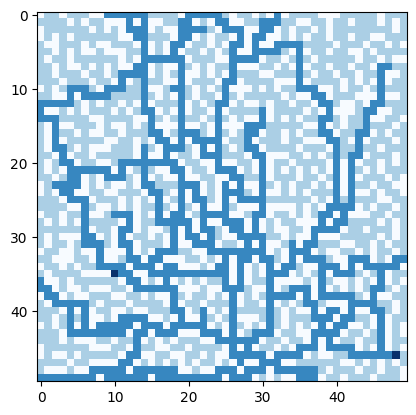

(1286, [(46, 48), (35, 10)])

In [17]:
seed = random.randint(0, 1000000000)
ship = Ship(seed = seed, leaks = 2)
print(seed)
print(ship.initial_leaks)
bot = BotSeven(ship, .5)
ship.display(bot.position)
success, path, steps = bot.simulate()
ship.display(list(path))
steps, ship.initial_leaks

### Bot 8:
Bot 8 is exactly Bot 3, except that the probability updates must be corrected to account for the
fact that there are two leaks - how?

In [18]:
class BotEight(BotSeven):
    def __init__(self, ship, alpha):
        super().__init__(ship, alpha)

    def init_prob_matrix(self):
        """Initialize Probability Matrix, originally giving all OPEN CELLS equal chance of having the leak"""
        board = self.ship.board
        n = len(board)
        num_open_cells = len(self.ship.open_cells)
        default_prob = (1 / num_open_cells) ** 2
        prob_matrix = ProbKB(n, board, default_prob)
        return prob_matrix

    def update_no_leak(self):
        """Update prior beliefs based on entering a cell with no leak"""
        board = self.ship.board
        n = len(board)
        current_kb = self.prob_matrix
        result_kb = ProbKB(n)
        r, c = self.position

        not_curr = 1 - self.probability_at_pos(self.position)
        for i in range(n):
            for j in range(n):
                for k in range(i, n):
                    for l in range(j + 1, n) if i == k else range(n):
                        a, b = (i, j), (k, l)
                        curr_prob = current_kb.get(a, b)
                        new_prob = curr_prob / not_curr
                        result_kb.set(a, b, new_prob)
                        
        result_kb.zero_out(self.position)
        
        self.prob_matrix = result_kb

    def update_based_on_beep(self, heard_beep, beep_prob):
        """Update prior beliefs based on hearing or not hearing a beep at a given cell"""
        board = self.ship.board
        n = len(board)
        current_kb = self.prob_matrix
        result_kb = ProbKB(n)
        denominator = 0

        for i in range(n):
            for j in range(n):
                if board[i][j] == Cell.BLOCKED:
                    continue
                    
                for k in range(i, n):
                    for l in range(j + 1, n) if i == k else range(n):
                        if board[k][l] == Cell.BLOCKED:
                            continue
                            
                        a, b = (i, j), (k, l)
                        curr_prob = current_kb.get(a, b)
                        if curr_prob == 0:
                            continue
                            
                        beep_ij = self.get_beep_prob(self.position, a)
                        beep_kl = self.get_beep_prob(self.position, b)
                        numerator = (beep_ij + beep_kl) - (beep_ij * beep_kl)
                        result_kb.set(a, b, numerator)
                        denominator += numerator
                        
        for i in range(n):
            for j in range(n):
                for k in range(i, n):
                    for l in range(j + 1, n) if i == k else range(n):
                        a, b = (i, j), (k, l)
                        curr_prob = result_kb.get(a, b)
                        new_prob = curr_prob / denominator
                        result_kb.set(a, b, new_prob)

        self.prob_matrix = result_kb    

    def probability_at_pos(self, pos):
        """Marginalize over every potential pair for cell `pos` to find it's individual prob"""
        prob = 0
        curr_kb = self.prob_matrix.probs
        for key, val in curr_kb.items():
            if pos in key:
                prob += val
            
        return prob




891891914
[(15, 4), (11, 13)]


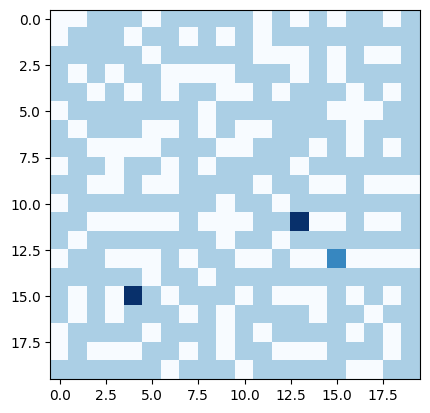

Moving from (13, 15) to (13, 15) with probability 0.003816737863507574
Moving from (13, 15) to (12, 15) with probability 0.06972015846093715
Moving from (12, 15) to (12, 14) with probability 0.06995693175372716
Moving from (12, 14) to (12, 13) with probability 0.0742751934305456
Moving from (12, 13) to (11, 13) with probability 0.07374226434595234
Plugged leak at (11, 13)
Moving from (11, 13) to (10, 13) with probability 0.07436392242718218
Moving from (10, 13) to (9, 13) with probability 0.07173677886420671
Moving from (9, 13) to (9, 12) with probability 0.07350413237688341
Moving from (9, 12) to (8, 12) with probability 0.07227181629529364
Moving from (8, 12) to (7, 12) with probability 0.06989918932227883
Moving from (7, 12) to (6, 12) with probability 0.07092468997440624
Moving from (6, 12) to (5, 12) with probability 0.07236264247354975
Moving from (5, 12) to (5, 11) with probability 0.07358855466156271
Moving from (5, 11) to (4, 11) with probability 0.07660857949983824
Moving fro

In [ ]:
seed = random.randint(0, 1000000000)
ship = Ship(D = 20, seed = seed, leaks = 2)
print(seed)
print(ship.initial_leaks)
bot = BotEight(ship, .5)
ship.display(bot.position)
#bot.prob_matrix
success, path, steps = bot.simulate()
#ship.display(list(path))
#steps, ship.initial_leaks

### Misc.

In [ ]:
file1 = open('seeds.txt', 'w')
for seed in np.random.randint(low=0, high=1000000000, size=1000):
    file1.write(str(seed) + "\n")
    print(seed)
file1.close()

In [ ]:
# Load Seeds
SEEDS_FILE_PATH = 'seeds.txt'
number_of_seeds = 100 # seeds.txt has 1000 seeds
SEEDS = []
with open(SEEDS_FILE_PATH, 'r') as seeds_file:
    reader = csv.reader(seeds_file)
    for row in reader:
        if number_of_seeds == 0:
            break
        number_of_seeds -= 1
        SEEDS.append(int(row[0]))   

In [ ]:
seed = random.randint(0, 1000000000)
ship = Ship(seed = seed, leaks = 2)
bot = BotEight(ship, .3)
ship.display()


In [ ]:
bot.probability_at_pos((0, 4)), 1 / len(ship.open_cells)

In [ ]:
ship = Ship(D = 4, leaks = 2)
bot = BotEight(ship, .3)
bot.prob_matrix.zero_out(bot.position)
bot.update_no_leak()
